# DeepWalk
DeepWalk consists of 'Word2Vec' and 'random walks'. It uses short random walks to learn representations for vertices in graphs.
## Word2Vec
Deep learning technique in NLP to translate words into vectors (embeddings) using large datasets of text. A neural network model is trained on text where the hidden layer in in the model is used to produce these vectors. The output for the model isn't necessarily used.
* **Continuous bag-of-words - CBOW** - Predict a word using its surrounding context (words coming before and after the target word). The order of the word isn't used as the embeddings are summed in the model.
* **Continuous skip-gram** - Single word used to predict the words around it

CBOW is faster to train, however the skip-gram model is more accurate as it can learn infrequent words. DeepWalk uses the skip-gram implementation.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import re
import random
from gensim.models.word2vec import Word2Vec

In [2]:
np.random.seed(0)
random.seed(0)

In [3]:
CONTEXT_SIZE = 2

text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nunc eu sem 
scelerisque, dictum eros aliquam, accumsan quam. Pellentesque tempus, lorem ut 
semper fermentum, ante turpis accumsan ex, sit amet ultricies tortor erat quis 
nulla. Nunc consectetur ligula sit amet purus porttitor, vel tempus tortor 
scelerisque. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices 
posuere cubilia curae; Quisque suscipit ligula nec faucibus accumsan. Duis 
vulputate massa sit amet viverra hendrerit. Integer maximus quis sapien id 
convallis. Donec elementum placerat ex laoreet gravida. Praesent quis enim 
facilisis, bibendum est nec, pharetra ex. Etiam pharetra congue justo, eget 
imperdiet diam varius non. Mauris dolor lectus, interdum in laoreet quis, 
faucibus vitae velit. Donec lacinia dui eget maximus cursus. Class aptent taciti
sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Vivamus
tincidunt velit eget nisi ornare convallis. Pellentesque habitant morbi 
tristique senectus et netus et malesuada fames ac turpis egestas. Donec 
tristique ultrices tortor at accumsan.
""".split()

In [4]:
text = [re.sub(r'[^\w\s]', '', t) for t in text]

In [5]:
skipgrams = []
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    skipgrams.append((text[i], text[i - CONTEXT_SIZE: i] + text[i + 1: i + CONTEXT_SIZE + 1]))

`('target word', ['context words'])` - 2 words preceeding and following the target word

In [6]:
skipgrams[0:2]

[('dolor', ['Lorem', 'ipsum', 'sit', 'amet']),
 ('sit', ['ipsum', 'dolor', 'amet', 'consectetur'])]

In [7]:
vocab = set(text)
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

112

Train a model to predict the context word given the target word. The model predicts the probability of seeing the context word given the target word.

`vector_size` is the dimensionality of the word vector. This is typically 100 or 1,000, however 10 is used here due to the limited size of the dataset.

The skip-gram model is composed of two layers: a **projection** layer which corresponds to a word embedding with dimension `vector_size`, a **fully connnected** layer of size `VOCAB_SIZE`. The fully connected layer contains logits whcih can be converted to probabilities using the softmax function. There is no activation function, i.e. Word2Vec is a linear classifier

In [8]:
model = Word2Vec(
    [text],
    sg=1,               # sg=1 refers to skip-gram, otherwise CBOW
    vector_size=10,     # Dimension of Embedding
    min_count=0,
    window=2,
    workers=1,
    seed=0
)
# size of first weight matrix is VOCAB_SIZE x Dim. of Embedding
model.wv.vectors.shape

(112, 10)

In [9]:
model.train([text], total_examples=model.corpus_count, epochs=10)

(652, 1560)

In [10]:
# Embedding of the first word in the vocab
model.wv[0]

array([ 0.06876274,  0.03164198,  0.00271081, -0.04791864, -0.03537949,
       -0.08163041, -0.09157088, -0.09718937, -0.06560754,  0.06836945],
      dtype=float32)

The method of above works for small models, however this model is computationally expensive for texts with millions of words due to the cost of applying the softmax function. To solve this, Word2Vec implements a technique called H-Softmax. H-Softmax uses a binary tree structure where the leaves are words. The Huffman tree cam be used which infrequent words re stored at deeper levels than common words. This gives a 50x speed increase. When using the `gensim` library, this can be enabled using `hs=1`.

## DeepWalk and random walks
Produce feature representations of nodes in an unsupervised way, similar to how embeddings are created in Word2Vec. Use random walks to generate sequences of nodes that act like scentences.

**Network homophilly** - nodes that are close to each other are similar

The following implements a random walk function

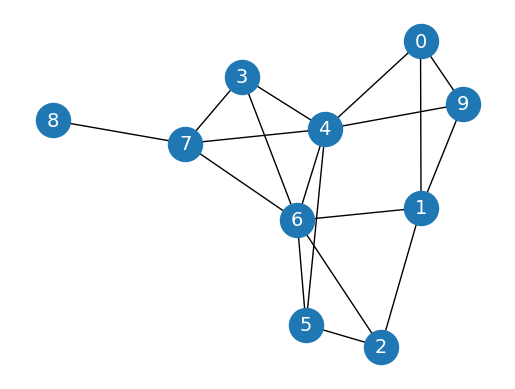

In [11]:
# generate a random graph with the erdos_renyi_graph function with a fixed number of nodes (10)
# and a predefined probability of creating an edge between two nodes (0.3)
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

plt.figure()
plt.axis('off')
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=0),
    node_size=600,
    cmap='coolwarm',
    font_size=14,
    font_color='white'
)

In [12]:
def random_walk(start, length):
    walk = [str(start)]  # starting node
    
    for i in range(length):
        neighbors = [node for node in G.neighbors(start)]
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(str(next_node))
        start = next_node
    
    return walk

In [13]:
random_walk(0, 10)

['0', '1', '9', '1', '0', '4', '6', '7', '6', '5', '6']

Nodes which are similar often appear next to each other in the random walk, e.g. `0, 1` and `6, 5`

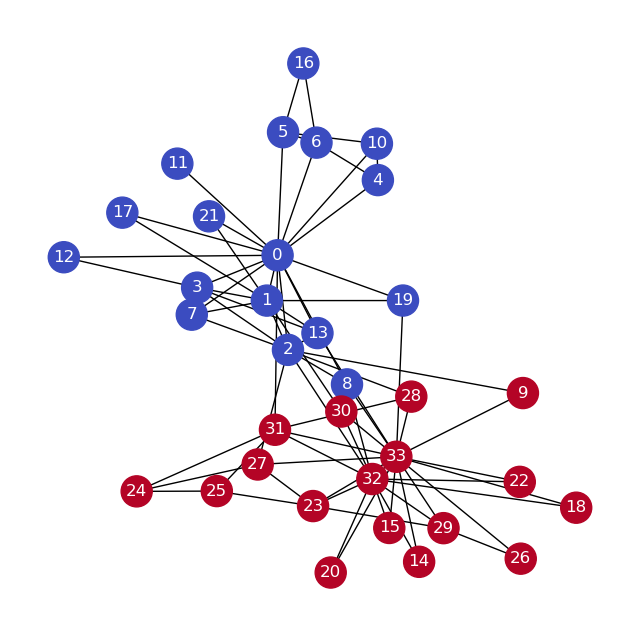

In [14]:
G = nx.karate_club_graph()

# Process labels (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# Plot graph
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=0),
    node_color=labels,
    node_size=500,
    cmap='coolwarm',
    font_size=12,
    font_color='white'
)

In [15]:
# Generate 80 random walks of length 10
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10))

walks[0]

['0', '10', '0', '17', '0', '2', '13', '0', '2', '9', '33']

In [16]:
model = Word2Vec(
    walks,
    hs=1,   # Hierarchical softmax
    sg=1,   # Skip-gram
    vector_size=100,
    window=10,
    workers=1,
    seed=1
)

model.wv.vectors.shape

(34, 100)

In [17]:
model.build_vocab(walks)
model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1)

(186095, 897600)

In [18]:
print('Nodes that are the most similar to node 0:')
for similarity in model.wv.most_similar(positive=['0']):
    print(f'   {similarity}')

print(f"\nSimilarity between node 0 and 4: {model.wv.similarity('0', '4')}")

Nodes that are the most similar to node 0:
   ('7', 0.6418731808662415)
   ('11', 0.6362531781196594)
   ('10', 0.6353079676628113)
   ('4', 0.6283926367759705)
   ('1', 0.6240348219871521)
   ('17', 0.6081663370132446)
   ('6', 0.576344907283783)
   ('5', 0.5598761439323425)
   ('21', 0.5572159290313721)
   ('16', 0.5503930449485779)

Similarity between node 0 and 4: 0.62839275598526


Plot the embeddings using t-distributed stochastic neighbor embedding (t-SNE) to show similar nodes are grouped together

c:\Users\priye\miniconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


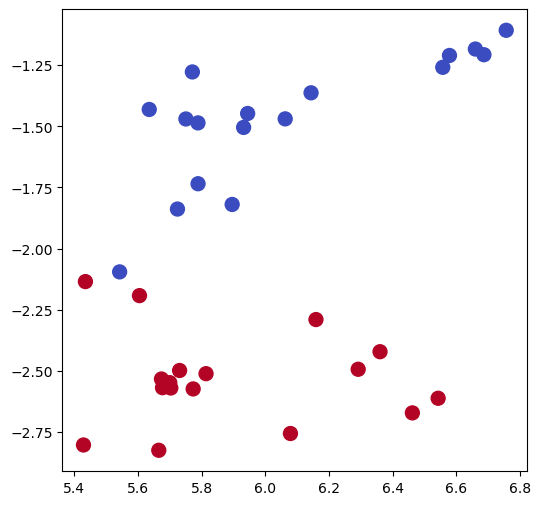

In [19]:
from sklearn.manifold import TSNE

# Preprocess word vectors and label
nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])
labels = np.array(labels)

# Train TSNE
tsne = TSNE(
    n_components=2,
    learning_rate='auto',
    init='pca',
    random_state=0
).fit_transform(nodes_wv)

# Plot TSNE
plt.figure(figsize=(6, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap="coolwarm")
plt.show()

Build a classifier to predict the label of the node

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create masks to train and test the model
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]

# Train classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(nodes_wv[train_mask], labels[train_mask])

# Evaluate accuracy
y_pred = clf.predict(nodes_wv[test_mask])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Accuracy = {acc*100:.2f}%')

Accuracy = 90.91%
